# Sampling a posterior

This notebook shows the basic usage of `cogwheel`.

We will choose an event, a waveform approximant and a prior and generate samples from the posterior distribution.

In [1]:
import sys
path_to_cogwheel = '/home/zihanz/git_cogwheel/cogwheel'
sys.path.append(path_to_cogwheel)
#sys.path.insert(0,"/home/hschia/data/love")
#sys.path.insert(-1, "/home/hschia/PE/gw_detection_ias")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt?

from cogwheel import data
from cogwheel import gw_prior
from cogwheel import likelihood
from cogwheel import sampling
from cogwheel import waveform
from cogwheel import gw_plotting
from cogwheel import posterior


from cogwheel.gw_prior import IntrinsicAlignedSpinIASPrior
from cogwheel.likelihood import MarginalizedExtrinsicLikelihoodQAS
import cogwheel.waveform_models.quadrupole_dissipation_octupole_love
from cogwheel.waveform_models.quadrupole_dissipation_octupole_love import IntrinsicQDOLPrior,\
QuadrupoleDissipationOctupoleLoveMarginalizedExtrinsicLikelihoodQAS,\
QuadrupoleDissipationOctupoleLoveWaveformGenerator, DEFAULT_PARS

%matplotlib inline


# Functions that transform parameters
def eta(m1,m2):
    return m1*m2/(m1+m2)**2

def q_from_eta(eta):
    return (1-np.sqrt(1-4*eta)-2*eta)/(2*eta)

def mchirp(m1, m2):
    return (m1+m2)*eta(m1,m2)**0.6

def kappa_s(kappa1, kappa2):
    return (kappa1 + kappa2)/2

def kappa_a(kappa1, kappa2):
    return (kappa1 - kappa2)/2

def lambda_s(lambda1, lambda2):
    return (kappa1 + kappa2)/2

def lambda_a(lambda1, lambda2):
    return (lambda1 - lambda2)/2

def leff(m1, m2, l1, l2):
    return (16/13) * ((m1+12*m2)*m1**4 * l1 + (m2 + 12*m1)*m2**4 * l2) / (m1 + m2)**5

def hs(m1, m2, h1, h2):
    return (h1*m1**3 + h2*m2**3)/(m1+m2)**3

def ha(m1, m2, h1, h2):
    return (h1*m1**3 - h2*m2**3)/(m1 + m2)**3

def h0(m1, m2, h1, h2):
    return (h1*m1**4 + h2*m2**4)/(m1 + m2)**4

Object `plt` not found.


## Event options

For now, we will use one of the preprocessed `EventData` files included:

In [2]:
eventnames = sorted(path.name.removesuffix('.npz')
                    for path in data.DATADIR.glob('*.npz'))
print('Available eventnames:')
eventnames;

Available eventnames:



## Approximant options

Pick one from the keys below. Approximants with aligned spins require that the prior has aligned spins as well.

In [3]:
waveform.APPROXIMANTS

{'IMRPhenomD_NRTidalv2': Approximant(harmonic_modes=[(2, 2)], aligned_spins=True, tides=True, hplus_hcross_func=<function compute_hplus_hcross at 0x7f6013a9f310>),
 'IMRPhenomD': Approximant(harmonic_modes=[(2, 2)], aligned_spins=True, tides=False, hplus_hcross_func=<function compute_hplus_hcross at 0x7f6013a9f310>),
 'IMRPhenomXPHM': Approximant(harmonic_modes=[(2, 2), (2, 1), (3, 3), (3, 2), (4, 4)], aligned_spins=False, tides=False, hplus_hcross_func=<function compute_hplus_hcross at 0x7f6013a9f310>),
 'IMRPhenomXAS': Approximant(harmonic_modes=[(2, 2)], aligned_spins=True, tides=False, hplus_hcross_func=<function compute_hplus_hcross at 0x7f6013a9f310>),
 'IMRPhenomXP': Approximant(harmonic_modes=[(2, 2)], aligned_spins=False, tides=False, hplus_hcross_func=<function compute_hplus_hcross at 0x7f6013a9f310>),
 'quadrupole_dissipation_octupole_love': Approximant(harmonic_modes=[(2, 2)], aligned_spins=True, tides=False, hplus_hcross_func=<function compute_hplus_hcross_quadrupole_dissi

## Instantiating a `Posterior`

In [4]:
metadata = pd.read_csv(data.DATADIR/'events_metadata.csv', index_col=0)  # Chirp mass guesses

In [5]:
# filter events with chirp mass smaller than 15
low_mass_events = metadata[(metadata['mchirp'] > 15) & (metadata['mchirp']<20)]

low_mass_events['mchirp'].keys()

Index(['GW151012', 'GW190412', 'GW190512_180714', 'GW190708_232457',
       'GW190828_065509', 'GW190925_232845', 'GW200225_060421'],
      dtype='object')

In [6]:
# Choose from the above options:
eventname = 'GW151226'
mchirp_guess = metadata['mchirp'][eventname]
delta_tc = 0.1

post0 = posterior.Posterior.from_event(eventname, mchirp_guess, 'IMRPhenomD', 'AlignedSpinIASPrior', 
                            prior_kwargs={'symmetrize_lnq': True},
                            ref_wf_finder_kwargs={'time_range':{-delta_tc, delta_tc}})

Searching incoherent solution for GW151226
Set intrinsic parameters, lnL = 91.51309758487417
Set time, lnL(H) = 61.97989291776419
Set sky location, lnL = 91.89055993477693
Set phase and distance, lnL = 91.89055993477693
Set mchirp_range = (9.182068403841066, 10.345743284317834)


In [7]:
import copy

approximant = 'quadrupole_dissipation_octupole_love'

new_like = QuadrupoleDissipationOctupoleLoveMarginalizedExtrinsicLikelihoodQAS(**copy.deepcopy(post0.likelihood).get_init_dict())
new_like.waveform_generator = QuadrupoleDissipationOctupoleLoveWaveformGenerator(**post0.likelihood.waveform_generator.get_init_dict() | {'approximant': approximant})
new_prior = IntrinsicQDOLPrior(**post0.prior.get_init_dict() | {'symmetrize_lnq': True, #'spin_quadrupole_rng':(-10000, 10000), 
                                          'schw_dissipation_rng': (0, 10000), 'spin1_dissipation_rng': (-10000,0)
                                          #'spin3_dissipation_rng':(-10000,0)
                                         #, 'spin_octupole_rng':(-10000, 10000), 
                                          #'max_tidal_deformability': 10000
                                         })
post = posterior.Posterior(new_prior, new_like)

In [8]:
post.likelihood.par_dic_0 = DEFAULT_PARS | post.likelihood.par_dic_0

In [9]:
post.prior.inverse_transform(**post.likelihood.par_dic_0)

{'mchirp': 9.717732179965118,
 'lnq': -0.6465092399970601,
 'cums1z': 0.7806904760194678,
 'cums2z': 0.7806904760194678,
 'h1s1': -0.17777777777777778,
 'h2s1': -0.17777777777777778}

In [10]:
post.prior.sampled_params

['mchirp', 'lnq', 'cums1z', 'cums2z', 'h1s1', 'h2s1']

In [10]:
# debug = cogwheel.posterior.debug
# debug['likelihood']
# debug['prior'].standard_params

Things you might want to double-check at this point:

* Did the maximizer find a high likelihood solution ($\log \mathcal{L} \approx \rm{SNR}^2 / 2$)?
* Is the automatically chosen `mchirp_range` ok?
* Are the default `q_min` and `dt0` ok?

In [ ]:
%%time

# Run the sampler and postprocess:
pym = sampling.PyMultiNest(post, sample_prior=False)
pym.run_kwargs['n_live_points'] = 256

parentdir = 'GW2023'  # Directory that will contain parameter estimation runs
rundir = pym.get_rundir(parentdir)
print('PE rundir:', rundir)
pym.run(rundir)


PE rundir: GW2023/IntrinsicQDOLPrior/GW151226/run_0
 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  256
 dimensionality =    6
 *****************************************************


/home/zihanz/git_cogwheel/cogwheel/cogwheel/likelihood/marginalization/base.py:327: UserWarning: Maximum QMC resolution reached.
  warnings.warn('Maximum QMC resolution reached.')


## Individual Analysis on "Bad" Events: Mchirp not accurate

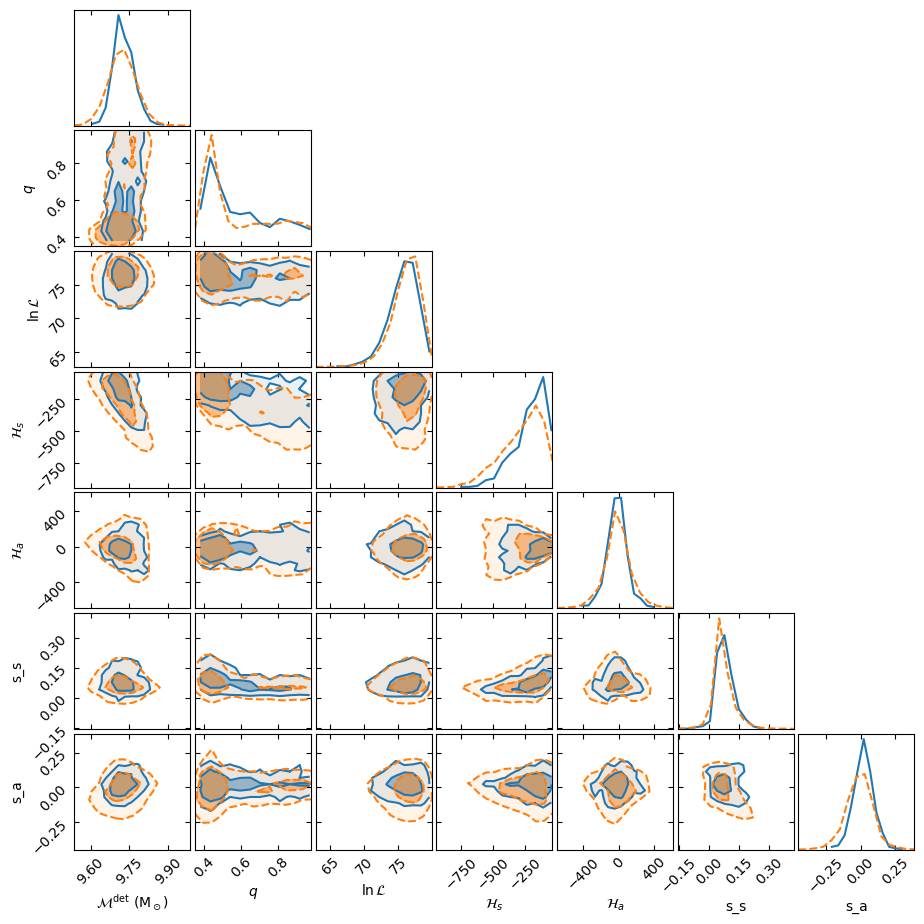

In [14]:
samples1 = pd.read_feather('GW2023/IntrinsicQDOLPrior/GW151226/run_0/samples.feather')
samples1['q'] = samples1['m2'] / samples1['m1']
    
samples1['h1s0'] = -2.0 * samples1['h1s1']
samples1['h2s0'] = -2.0 * samples1['h2s1']
    
samples1['hs'] = hs(samples1['m1'], samples1['m2'], 
                                   samples1['h1s1'], samples1['h2s1'])
samples1['ha'] = ha(samples1['m1'], samples1['m2'], 
                                   samples1['h1s1'], samples1['h2s1'])
samples1['h0'] = h0(samples1['m1'], samples1['m2'], 
                samples1['h1s0'], samples1['h2s0'])
samples1['s_s'] = (samples1['s1z'] + samples1['s2z']) / 2.0
samples1['s_a'] = (samples1['s1z'] - samples1['s2z']) / 2.0
samples1['chieff'] = (samples1['s1z']*samples1['m1'] \
                                     + samples1['s2z']*samples1['m2']) \
                                     /(samples1['m1'] + samples1['m2'])


samples2 = pd.read_feather('/home/zihanz/custom-waveform-model/cogwheel/cogwheel/waveform_models/GW2023/IntrinsicQDOLPrior/GW151226/live2048_4PN_supcon/samples.feather')
samples2['q'] = samples2['m2'] / samples2['m1']
    
samples2['h1s0'] = -2.0 * samples2['h1s1']
samples2['h2s0'] = -2.0 * samples2['h2s1']
    
samples2['hs'] = hs(samples2['m1'], samples2['m2'], 
                                   samples2['h1s1'], samples2['h2s1'])
samples2['ha'] = ha(samples2['m1'], samples2['m2'], 
                                   samples2['h1s1'], samples2['h2s1'])
samples2['h0'] = h0(samples2['m1'], samples2['m2'], 
                samples2['h1s0'], samples2['h2s0'])
samples2['s_s'] = (samples2['s1z'] + samples2['s2z']) / 2.0
samples2['s_a'] = (samples2['s1z'] - samples2['s2z']) / 2.0
samples2['chieff'] = (samples2['s1z']*samples2['m1'] \
                                     + samples2['s2z']*samples2['m2']) \
                                     /(samples2['m1'] + samples2['m2'])

plot_params=['mchirp','q','lnl','hs','ha','s_s','s_a']
gw_plotting.MultiCornerPlot([samples1[plot_params], samples2[plot_params]]).plot()

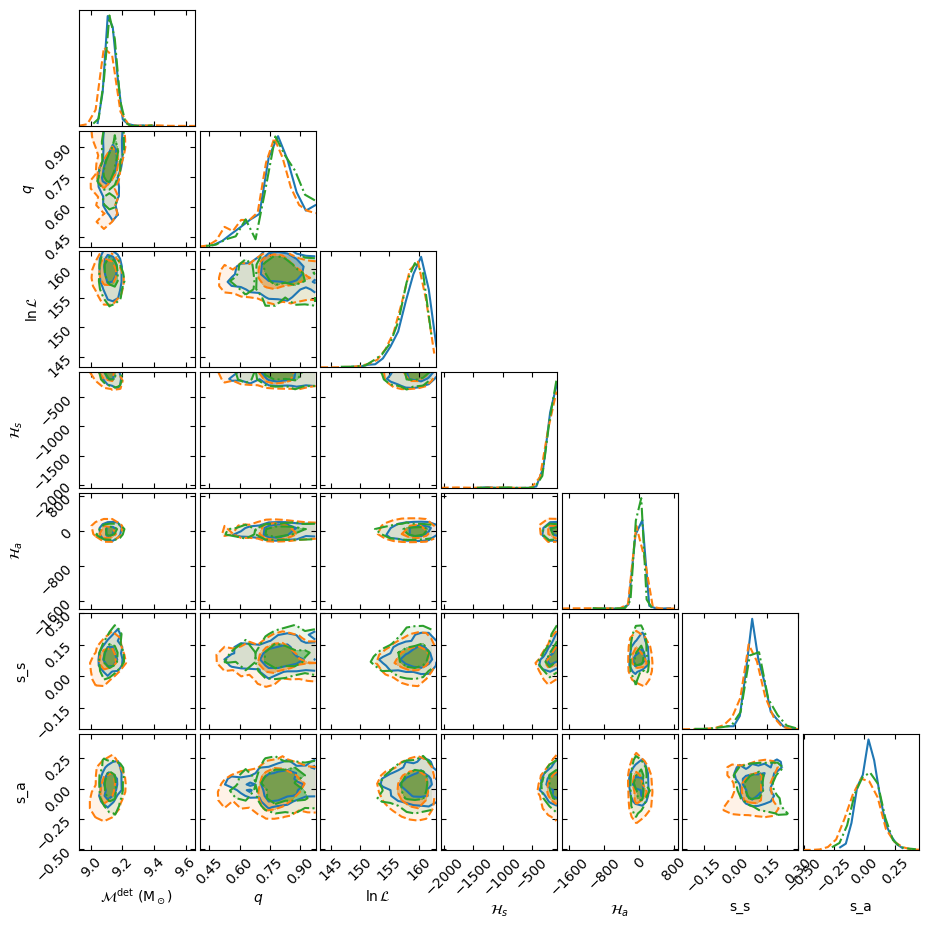

In [14]:
samples1 = pd.read_feather('GW2023/IntrinsicQDOLPrior/GW191216_213338/run_1/samples.feather')
samples1['q'] = samples1['m2'] / samples1['m1']
    
samples1['h1s0'] = -2.0 * samples1['h1s1']
samples1['h2s0'] = -2.0 * samples1['h2s1']
    
samples1['hs'] = hs(samples1['m1'], samples1['m2'], 
                                   samples1['h1s1'], samples1['h2s1'])
samples1['ha'] = ha(samples1['m1'], samples1['m2'], 
                                   samples1['h1s1'], samples1['h2s1'])
samples1['h0'] = h0(samples1['m1'], samples1['m2'], 
                samples1['h1s0'], samples1['h2s0'])
samples1['s_s'] = (samples1['s1z'] + samples1['s2z']) / 2.0
samples1['s_a'] = (samples1['s1z'] - samples1['s2z']) / 2.0
samples1['chieff'] = (samples1['s1z']*samples1['m1'] \
                                     + samples1['s2z']*samples1['m2']) \
                                     /(samples1['m1'] + samples1['m2'])


samples2 = pd.read_feather('/home/zihanz/custom-waveform-model/cogwheel/cogwheel/waveform_models/GW2023/IntrinsicQDOLPrior/GW191216_213338/live2048_4PN_supcon/samples.feather')
samples2['q'] = samples2['m2'] / samples2['m1']
    
samples2['h1s0'] = -2.0 * samples2['h1s1']
samples2['h2s0'] = -2.0 * samples2['h2s1']
    
samples2['hs'] = hs(samples2['m1'], samples2['m2'], 
                                   samples2['h1s1'], samples2['h2s1'])
samples2['ha'] = ha(samples2['m1'], samples2['m2'], 
                                   samples2['h1s1'], samples2['h2s1'])
samples2['h0'] = h0(samples2['m1'], samples2['m2'], 
                samples2['h1s0'], samples2['h2s0'])
samples2['s_s'] = (samples2['s1z'] + samples2['s2z']) / 2.0
samples2['s_a'] = (samples2['s1z'] - samples2['s2z']) / 2.0
samples2['chieff'] = (samples2['s1z']*samples2['m1'] \
                                     + samples2['s2z']*samples2['m2']) \
                                     /(samples2['m1'] + samples2['m2'])

samples3 = pd.read_feather('GW2023/IntrinsicQDOLPrior/GW191216_213338/run_0/samples.feather')
samples3['q'] = samples3['m2'] / samples3['m1']
    
samples3['h1s0'] = -2.0 * samples3['h1s1']
samples3['h2s0'] = -2.0 * samples3['h2s1']
    
samples3['hs'] = hs(samples3['m1'], samples3['m2'], 
                                   samples3['h1s1'], samples3['h2s1'])
samples3['ha'] = ha(samples3['m1'], samples3['m2'], 
                                   samples3['h1s1'], samples3['h2s1'])
samples3['h0'] = h0(samples3['m1'], samples3['m2'], 
                samples3['h1s0'], samples3['h2s0'])
samples3['s_s'] = (samples3['s1z'] + samples3['s2z']) / 2.0
samples3['s_a'] = (samples3['s1z'] - samples3['s2z']) / 2.0
samples3['chieff'] = (samples3['s1z']*samples3['m1'] \
                                     + samples3['s2z']*samples3['m2']) \
                                     /(samples3['m1'] + samples3['m2'])


plot_params=['mchirp','q','lnl','hs','ha','s_s','s_a']
gw_plotting.MultiCornerPlot([samples1[plot_params], samples2[plot_params],samples3[plot_params]]).plot()

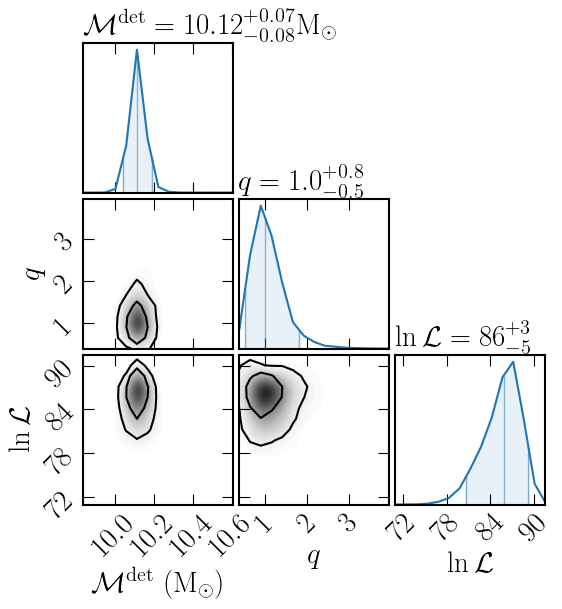

In [64]:
samples = pd.read_feather('GW2023/IntrinsicLVCPrior/GW190728_064510/run_0/samples.feather')
samples['q'] = np.exp(samples['lnq'])
gw_plotting.CornerPlot(samples[['mchirp','q','lnl']]).plot()

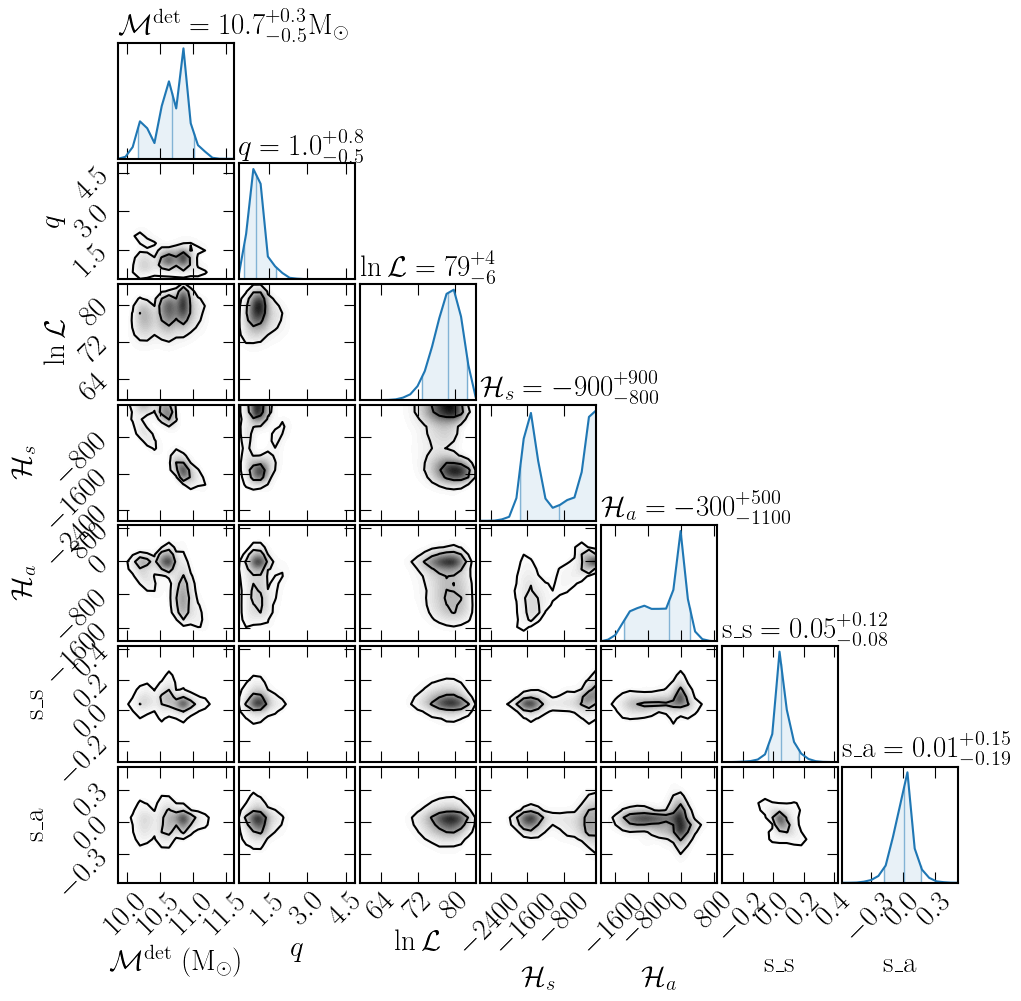

In [115]:
samples = pd.read_feather('GW2023/IntrinsicQDOLPrior/GW190728_064510/live8192_4PN_supcon/samples.feather')
samples['q'] = np.exp(samples['lnq'])
    
samples['h1s0'] = -2.0 * samples['h1s1']
samples['h2s0'] = -2.0 * samples['h2s1']
    
samples['hs'] = hs(samples['m1'], samples['m2'], 
                                   samples['h1s1'], samples['h2s1'])
samples['ha'] = ha(samples['m1'], samples['m2'], 
                                   samples['h1s1'], samples['h2s1'])
samples['h0'] = h0(samples['m1'], samples['m2'], 
                samples['h1s0'], samples['h2s0'])
samples['s_s'] = (samples['s1z'] + samples['s2z']) / 2.0
samples['s_a'] = (samples['s1z'] - samples['s2z']) / 2.0
samples['chieff'] = (samples['s1z']*samples['m1'] \
                                     + samples['s2z']*samples['m2']) \
                                     /(samples['m1'] + samples['m2'])
gw_plotting.CornerPlot(samples[['mchirp','q','lnl','hs','ha','s_s','s_a']]).plot()

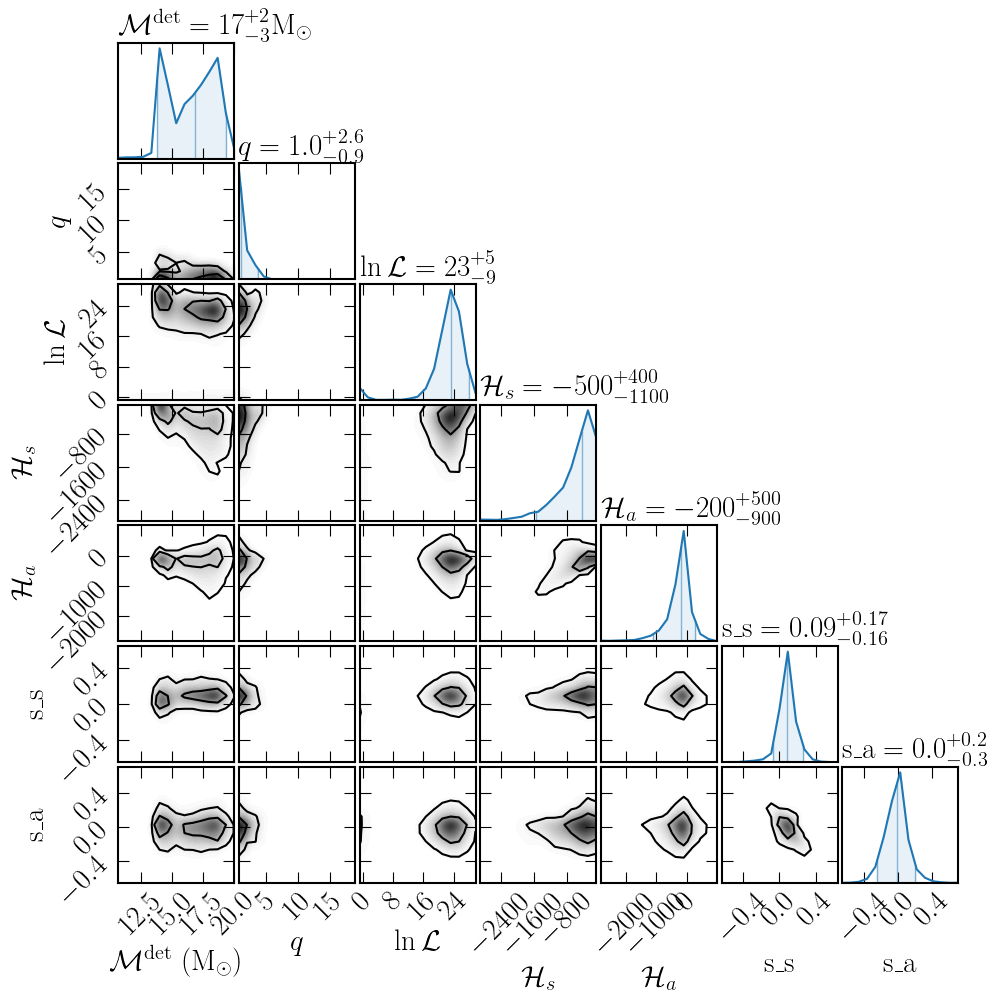

In [75]:
samples = pd.read_feather('GW2023/IntrinsicQDOLPrior/GW191113_071753/live2048_4PN_supcon/samples.feather')
samples['q'] = np.exp(samples['lnq'])
    
samples['h1s0'] = -2.0 * samples['h1s1']
samples['h2s0'] = -2.0 * samples['h2s1']
    
samples['hs'] = hs(samples['m1'], samples['m2'], 
                                   samples['h1s1'], samples['h2s1'])
samples['ha'] = ha(samples['m1'], samples['m2'], 
                                   samples['h1s1'], samples['h2s1'])
samples['h0'] = h0(samples['m1'], samples['m2'], 
                samples['h1s0'], samples['h2s0'])
samples['s_s'] = (samples['s1z'] + samples['s2z']) / 2.0
samples['s_a'] = (samples['s1z'] - samples['s2z']) / 2.0
samples['chieff'] = (samples['s1z']*samples['m1'] \
                                     + samples['s2z']*samples['m2']) \
                                     /(samples['m1'] + samples['m2'])

samples = samples[samples['hs']>-3000]
gw_plotting.CornerPlot(samples[['mchirp','q','lnl','hs','ha','s_s','s_a']]).plot()

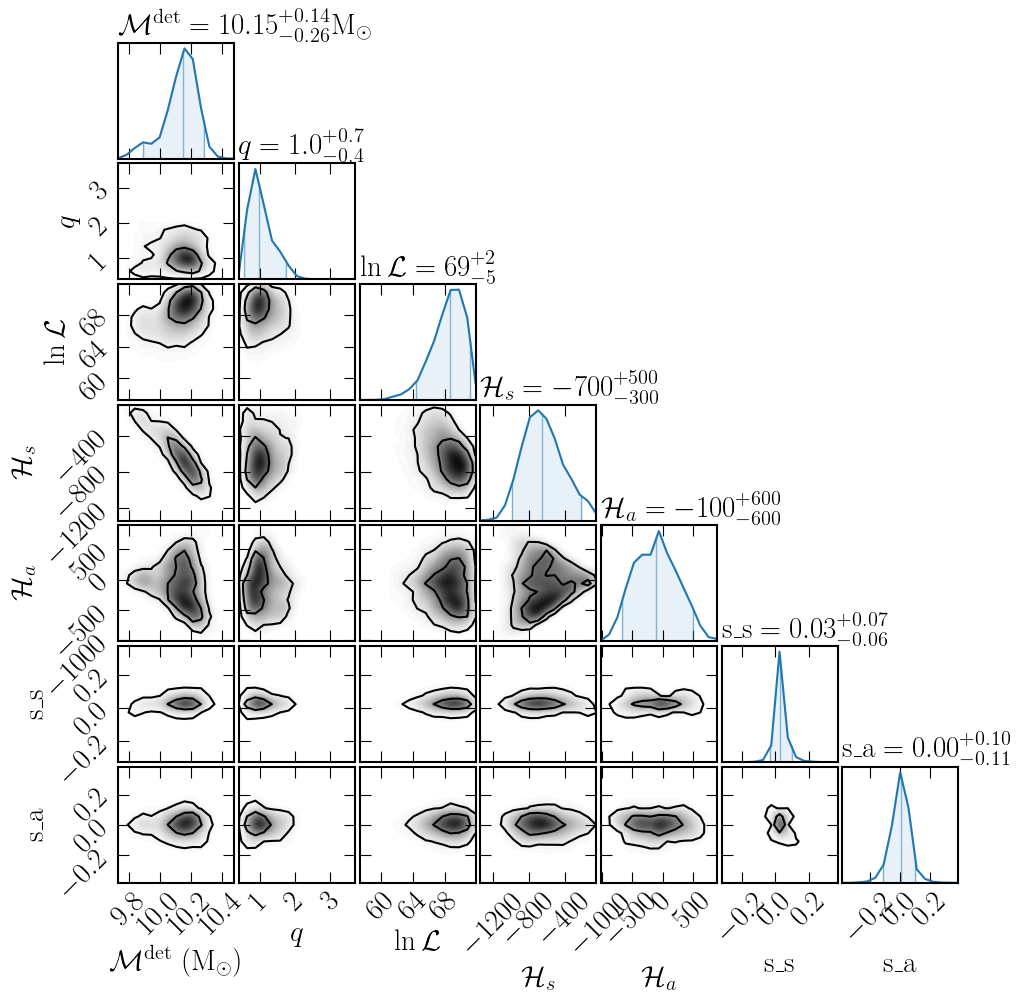

In [120]:
samples = pd.read_feather('GW2023/IntrinsicQDOLPrior/GW190707_093326/live2048_4PN_supcon/samples.feather')
samples['q'] = np.exp(samples['lnq'])
    
samples['h1s0'] = -2.0 * samples['h1s1']
samples['h2s0'] = -2.0 * samples['h2s1']
    
samples['hs'] = hs(samples['m1'], samples['m2'], 
                                   samples['h1s1'], samples['h2s1'])
samples['ha'] = ha(samples['m1'], samples['m2'], 
                                   samples['h1s1'], samples['h2s1'])
samples['h0'] = h0(samples['m1'], samples['m2'], 
                samples['h1s0'], samples['h2s0'])
samples['s_s'] = (samples['s1z'] + samples['s2z']) / 2.0
samples['s_a'] = (samples['s1z'] - samples['s2z']) / 2.0
samples['chieff'] = (samples['s1z']*samples['m1'] \
                                     + samples['s2z']*samples['m2']) \
                                     /(samples['m1'] + samples['m2'])

samples = samples[samples['hs']>-3000]
gw_plotting.CornerPlot(samples[['mchirp','q','lnl','hs','ha','s_s','s_a']]).plot()

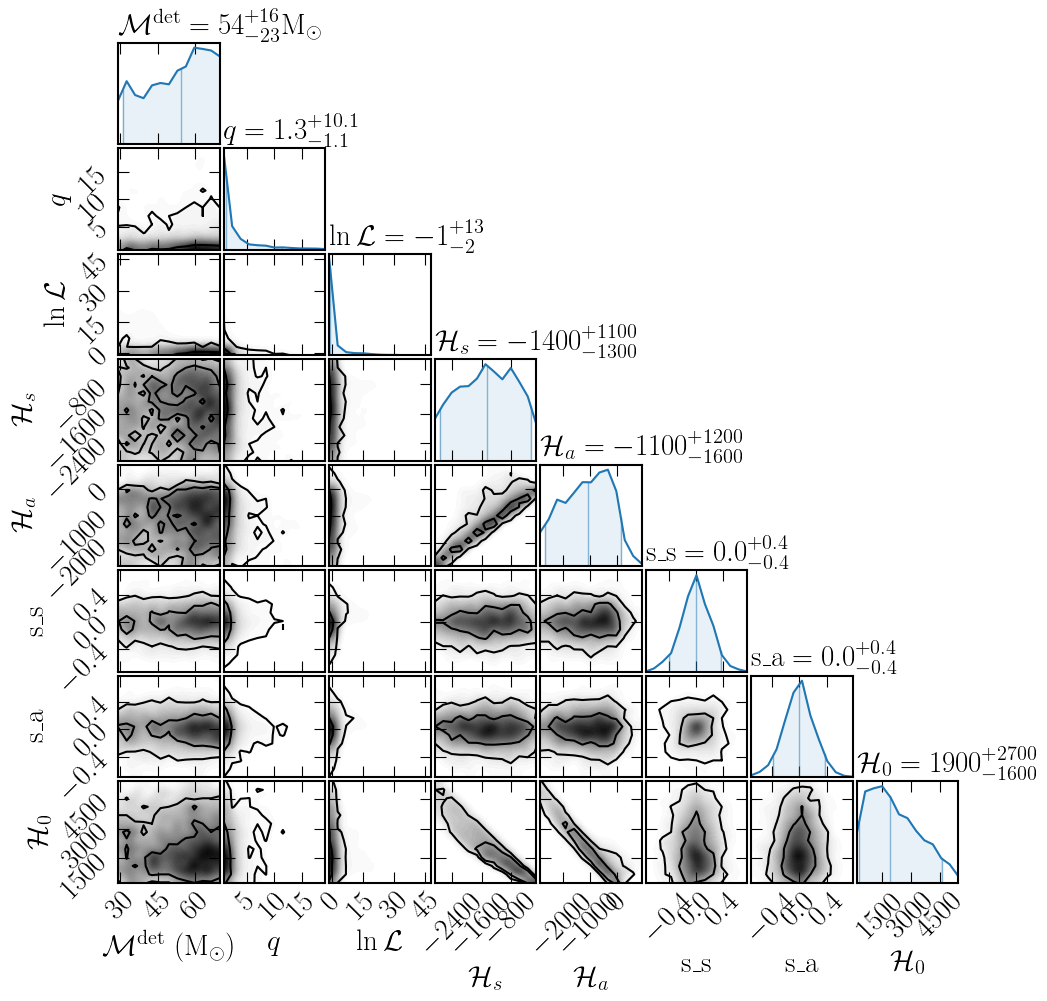

In [136]:
samples = pd.read_feather('GW2023/IntrinsicQDOLPrior/sample_prior/live2048_4PN_ppdiss/samples.feather')
samples['q'] = np.exp(samples['lnq'])
    
samples['h1s0'] = -2.0 * samples['h1s1']
samples['h2s0'] = -2.0 * samples['h2s1']
    
samples['hs'] = hs(samples['m1'], samples['m2'], 
                                   samples['h1s1'], samples['h2s1'])
samples['ha'] = ha(samples['m1'], samples['m2'], 
                                   samples['h1s1'], samples['h2s1'])
samples['h0'] = h0(samples['m1'], samples['m2'], 
                samples['h1s0'], samples['h2s0'])
samples['s_s'] = (samples['s1z'] + samples['s2z']) / 2.0
samples['s_a'] = (samples['s1z'] - samples['s2z']) / 2.0
samples['chieff'] = (samples['s1z']*samples['m1'] \
                                     + samples['s2z']*samples['m2']) \
                                     /(samples['m1'] + samples['m2'])

samples = samples[samples['hs']>-3000]
gw_plotting.CornerPlot(samples[['mchirp','q','lnl','hs','ha','s_s','s_a','h0']]).plot()

# All samples in a plot

## TaylorF2 Dissipation Waveform

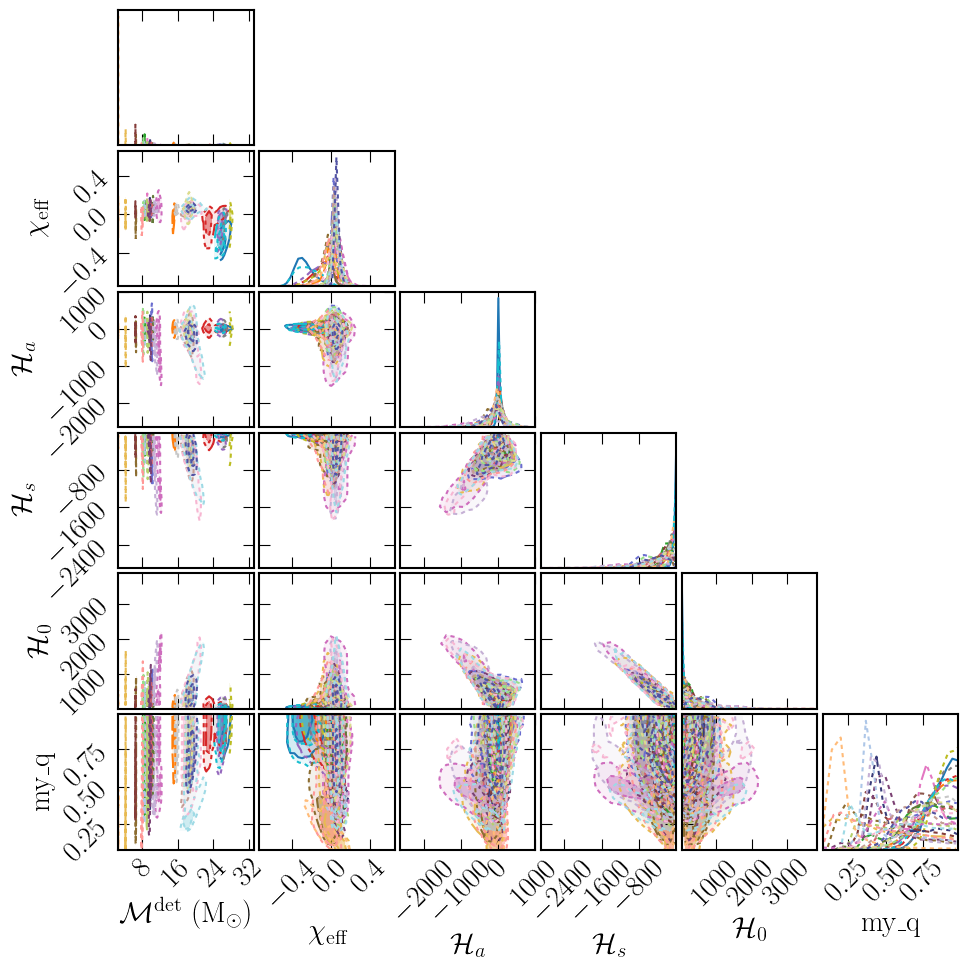

In [51]:
samples_Diss = {}
eventnames = ['GW150914','GW190412','GW170608','GW170814','GW190828_063405','GW191204_171526','GW191216_213338',
              'GW200129_065458','GW200224_222234','GW200311_115853','GW151226', 'GW190707_093326', 'GW190720_000836',
              'GW190725_174728', 'GW190814', 'GW190917_114630',
              'GW190924_021846', 'GW191103_012549',
              'GW191105_143521',  'GW191126_115259',
              'GW191129_134029', 'GW200115_042309', 'GW200202_154313',
              'GW200210_092254', 'GW200316_215756','GW151012', 'GW190512_180714', 'GW190708_232457',
       'GW190828_065509', 'GW190925_232845', 'GW200225_060421']

plot_params = ['mchirp','chieff','ha','hs','h0','my_q']

for event in eventnames:
    
    path = 'GW2023/IntrinsicQDOLPrior/' + event + '/live2048_4PN_supcon/samples.feather'
    samples_Diss[event]= pd.read_feather(path)
    
    #samples_Diss[event]['q'] = np.exp(samples_Diss[event]['lnq'])
    samples_Diss[event]['my_q'] = samples_Diss[event]['m2']/samples_Diss[event]['m1']
    
    samples_Diss[event]['h1s0'] = -2.0 * samples_Diss[event]['h1s1']
    samples_Diss[event]['h2s0'] = -2.0 * samples_Diss[event]['h2s1']
    
    samples_Diss[event]['hs'] = hs(samples_Diss[event]['m1'], samples_Diss[event]['m2'], 
                                   samples_Diss[event]['h1s1'], samples_Diss[event]['h2s1'])
    samples_Diss[event]['ha'] = ha(samples_Diss[event]['m1'], samples_Diss[event]['m2'], 
                                   samples_Diss[event]['h1s1'], samples_Diss[event]['h2s1'])
    samples_Diss[event]['h0'] = h0(samples_Diss[event]['m1'], samples_Diss[event]['m2'], 
                                   samples_Diss[event]['h1s0'], samples_Diss[event]['h2s0'])
    samples_Diss[event]['s_s'] = (samples_Diss[event]['s1z'] + samples_Diss[event]['s2z']) / 2.0
    samples_Diss[event]['s_a'] = (samples_Diss[event]['s1z'] - samples_Diss[event]['s2z']) / 2.0
    samples_Diss[event]['chieff'] = (samples_Diss[event]['s1z']*samples_Diss[event]['m1'] \
                                     + samples_Diss[event]['s2z']*samples_Diss[event]['m2']) \
                                     /(samples_Diss[event]['m1'] + samples_Diss[event]['m2'])
    samples_Diss[event]['event'] = event
    samples_Diss[event]['approximant'] = 'Dissipations'
    
    samples_Diss[event] = samples_Diss[event][(samples_Diss[event]['h0'] < 4000) \
                                              & (samples_Diss[event]['mchirp'] < 40)]


gw_plotting.MultiCornerPlot([samples_Diss[event][plot_params] for event in eventnames]).plot()

df_Diss = pd.concat(samples_Diss.values(), ignore_index=True)


In [34]:
import matplotlib

color_levels = np.array([i for i in np.linspace(0,1.0,20)])

tab10_iter = iter(matplotlib.cm.get_cmap("coolwarm")(color_levels))


eventnames = ['GW150914','GW190412','GW170608','GW170814','GW190828_063405','GW191204_171526','GW191216_213338',
              'GW200129_065458','GW200224_222234','GW200311_115853','GW151226', 'GW190707_093326', 'GW190720_000836',
              'GW190725_174728', 'GW190728_064510', 'GW190814', 'GW190917_114630',
              'GW190924_021846', 'GW190930_133541', 'GW191103_012549',
              'GW191105_143521', 'GW191113_071753', 'GW191126_115259',
              'GW191129_134029', 'GW200115_042309', 'GW200202_154313',
              'GW200210_092254', 'GW200316_215756']

for event in eventnames:

    plt.hist(samples[f'{event}']['hs'], bins=30, density=True,color = next(tab10_iter),linewidth=1.2,histtype='step',label = f'{event}') 
    plt.hist(samples[f'{event}']['hs'], bins=30,alpha = 0.1,color = next(tab10_iter), density=True,fill=True,  stacked=True) 
    
    
plt.hist(samples[f'sample_prior']['hs'], bins=30, density=True,color = 'gray',linewidth=1.2,histtype='step',label = f'Prior') 
plt.hist(samples[f'sample_prior']['hs'], bins=30,alpha = 0.1,color = 'gray', density=True,fill=True,  stacked=True) 

    
plt.xlim(-5000,0)
plt.xlabel(r'$\mathcal{H}_s$')
plt.gca().set_yticklabels([])
plt.legend(fontsize = 14)
plt.show()

color_levels = np.array([i for i in np.linspace(0,1.0,20)])

tab10_iter = iter(matplotlib.cm.get_cmap("coolwarm")(color_levels))

for event in eventnames:

    plt.hist(samples[f'{event}']['h0'], bins=30, density=True,color = next(tab10_iter),linewidth=1.2,histtype='step',label = f'{event}') 
    plt.hist(samples[f'{event}']['h0'], bins=30,alpha = 0.1,color = next(tab10_iter), density=True,fill=True,  stacked=True) 


plt.hist(samples[f'sample_prior']['h0'], bins=30, density=True,color = 'gray',linewidth=1.2,histtype='step',label = f'Prior') 
plt.hist(samples[f'sample_prior']['h0'], bins=30,alpha = 0.1,color = 'gray', density=True,fill=True,  stacked=True)     

plt.xlim(0,2000)
plt.xlabel(r'$\mathcal{H}_0$')
plt.gca().set_yticklabels([])
plt.legend(fontsize = 14)
plt.show()


/tmp/ipykernel_2858349/237631421.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  tab10_iter = iter(matplotlib.cm.get_cmap("coolwarm")(color_levels))


KeyError: 'GW150914'

## IMRPhenomXPHM LVC

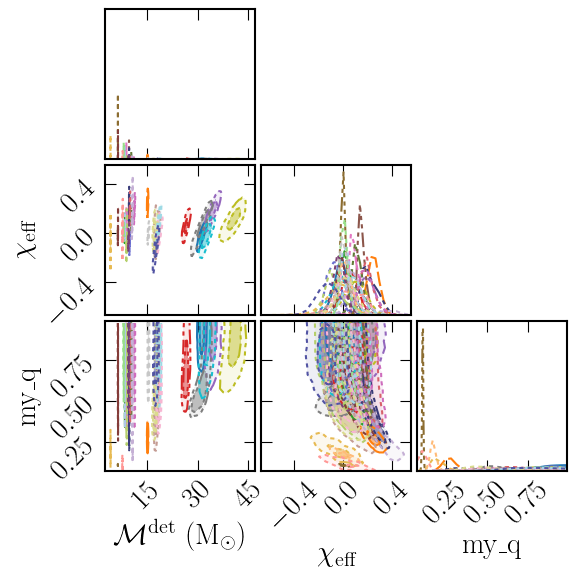

In [44]:
import seaborn as sns


samples_LVC = {}
eventnames = ['GW150914','GW190412','GW170608','GW170814','GW190828_063405','GW191204_171526','GW191216_213338',
              'GW200129_065458','GW200224_222234','GW200311_115853','GW151226', 'GW190707_093326', 'GW190720_000836',
              'GW190725_174728', 'GW190814', 'GW190917_114630',
              'GW190924_021846', 'GW191103_012549',
              'GW191105_143521',  'GW191126_115259',
              'GW191129_134029', 'GW200115_042309', 'GW200202_154313',
              'GW200210_092254', 'GW200316_215756','GW151012', 'GW190512_180714', 'GW190708_232457',
       'GW190828_065509', 'GW190925_232845', 'GW200225_060421']

for event in eventnames:
    path = 'GW2023/IntrinsicLVCPrior/' + event + '/symmetric_lnq/samples.feather'
    samples_LVC[event] = pd.read_feather(path)

    samples_LVC[event]['chieff'] = (samples_LVC[event]['s1z']*samples_LVC[event]['m1'] \
                                     + samples_LVC[event]['s2z']*samples_LVC[event]['m2']) \
                                     /(samples_LVC[event]['m1'] + samples_LVC[event]['m2'])

    #samples_LVC[event]['q'] = np.exp(samples_LVC[event]['lnq'])
    samples_LVC[event]['my_q'] = samples_LVC[event]['m2']/samples_LVC[event]['m1']
    samples_LVC[event]['event'] = event # add a column for event name
    samples_LVC[event]['approximant'] = 'IMRPhenomXPHM'

# concatenate all dataframes
df_LVC = pd.concat(samples_LVC.values(), ignore_index=True)

plot_params = ['mchirp','chieff','my_q']

gw_plotting.MultiCornerPlot([samples_LVC[event][plot_params] for event in eventnames]).plot()

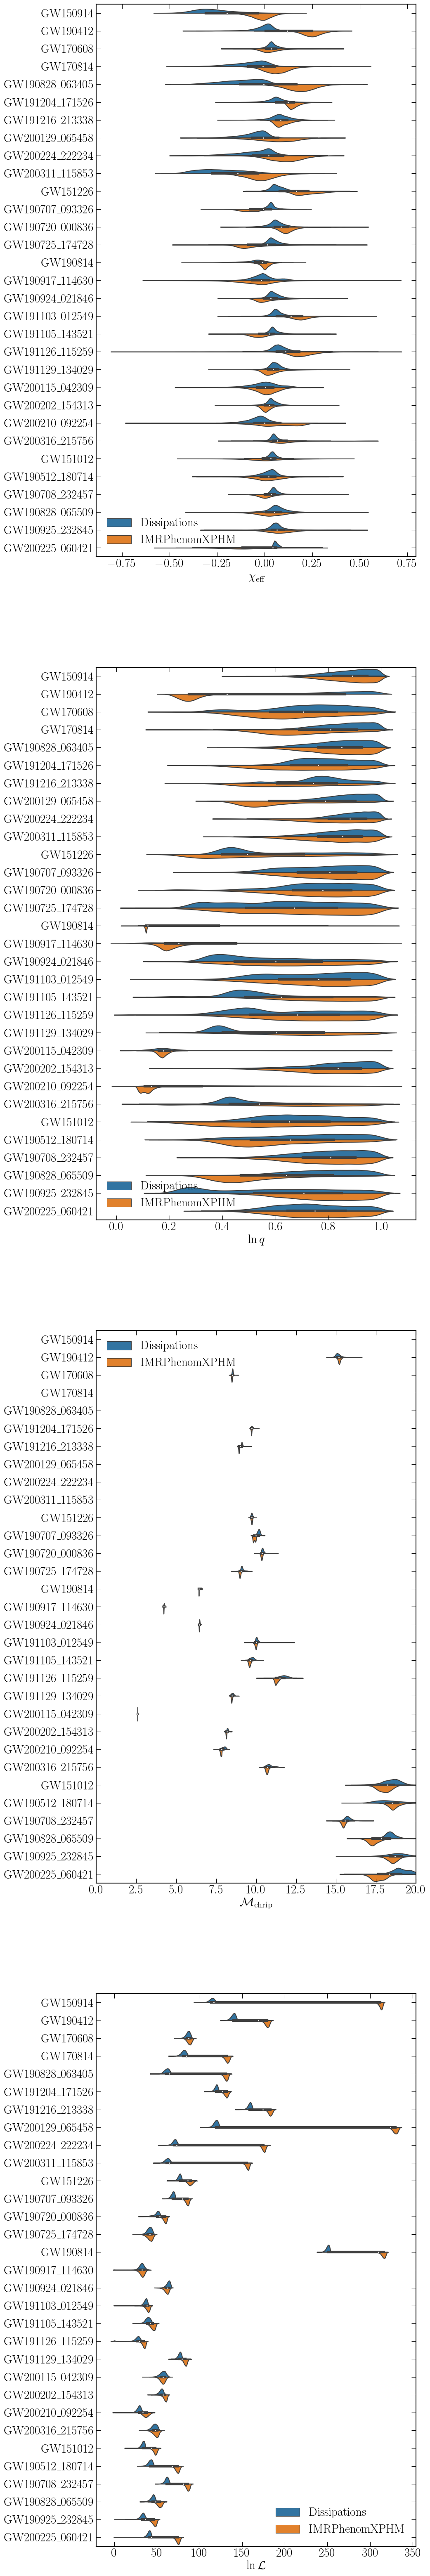

In [45]:
fig, ax = plt.subplots(4,1,figsize = (10,80))

# Merge the dataframes
df = pd.merge(df_Diss, df_LVC, how='outer')


## chi_eff

sns.violinplot(data=df, x="chieff", y="event", hue='approximant', split=True,ax=ax[0])


ax[0].set_xlabel(r'$\chi_{\rm eff}$')
ax[0].set_ylabel('')
legend = ax[0].legend()
legend.get_title().set_text('')


## lnq

sns.violinplot(data=df, x="my_q", y="event", hue='approximant', split=True,ax=ax[1])

ax[1].set_xlabel(r'$q$')
ax[1].set_ylabel('')
legend = ax[1].legend()
legend.get_title().set_text('')


## mchirp

sns.violinplot(data=df, x="mchirp", y="event", hue='approximant', split=True,ax=ax[2])

ax[2].set_xlabel(r'$\mathcal{M}_{\rm chrip}$')
ax[2].set_ylabel('')
legend = ax[2].legend()
legend.get_title().set_text('')

ax[2].set_xlim(0,20)

## lnl


sns.violinplot(data=df, x="lnl", y="event", hue='approximant', split=True, ax=ax[3])


# remove the legend title
ax[3].set_xlabel(r'$\ln \mathcal{L}$')
ax[3].set_ylabel('')
legend = ax[3].legend()
legend.get_title().set_text('')


## IMRPhenomXAS

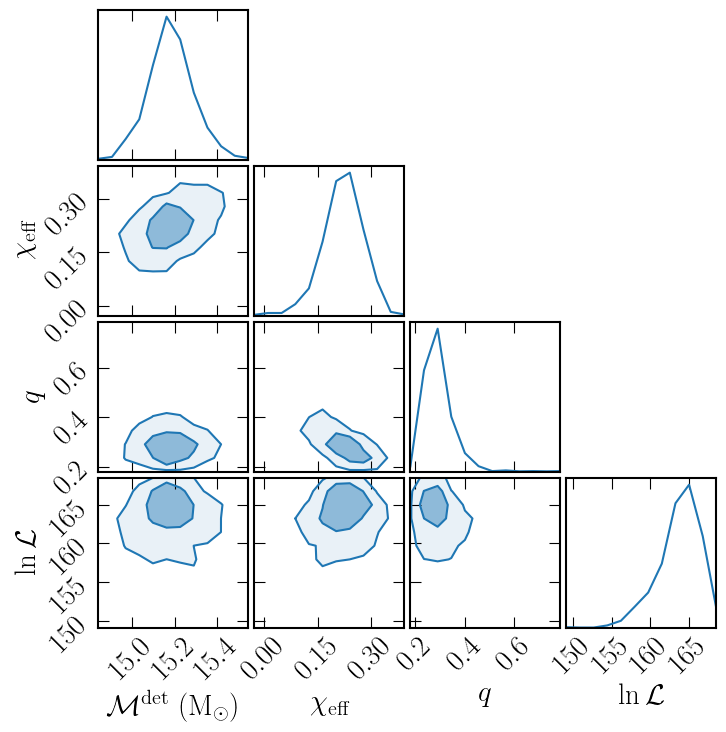

In [32]:
import seaborn as sns


samples_LVC = {}
eventnames = ['GW190412']

for event in eventnames:
    path = 'GW2023/IntrinsicAlignedSpinLVCPrior/' + event + '/run_0/samples.feather'
    samples_LVC[event] = pd.read_feather(path)
    
    samples_LVC[event]['q'] = np.exp(samples_LVC[event]['lnq'])

    samples_LVC[event]['chieff'] = (samples_LVC[event]['s1z']*samples_LVC[event]['m1'] \
                                     + samples_LVC[event]['s2z']*samples_LVC[event]['m2']) \
                                     /(samples_LVC[event]['m1'] + samples_LVC[event]['m2'])

    samples_LVC[event]['event'] = event # add a column for event name
    samples_LVC[event]['approximant'] = 'IMRPhenomXPHM'

# concatenate all dataframes
df_LVC = pd.concat(samples_LVC.values(), ignore_index=True)

plot_params = ['mchirp','chieff','q','lnl']

gw_plotting.MultiCornerPlot([samples_LVC[event][plot_params] for event in eventnames]).plot()